<a href="https://colab.research.google.com/github/vinhngx/DeepLearningExamples/blob/vinhn_unet_industrial_demo/TensorFlow/Segmentation/UNet_Industrial/notebooks/Colab_UNet_Industrial_TF_TRT_inference_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# UNet Industrial Inference Demo with TensorRT

## Overview


In this notebook, we will demo the process of carrying out inference on new images using a pre-trained UNet model downloaded from the NVIDIA NGC Model registry. We will also optimize the naitive TensorFlow trained model for deployment with TensorRT. TensorRT is the NVIDIA high-performance runtime environment for deployment of deep learning applications.

### Requirement
1. Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

For TensorRT FP16 and INT8 inference, an NVIDIA Volta, Turing or newer GPU generations is required. 

In [1]:
!nvidia-smi

Thu Oct 17 03:41:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

The below code checks whether a Tensor core GPU is present.

In [2]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


2. Next, we clone the Github UNet_Industrial repository and set up the workspace.

In [3]:
!git clone https://github.com/vinhngx/DeepLearningExamples

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 4084, done.
remote: Total 4084 (delta 0), reused 0 (delta 0), pack-reused 4084
Receiving objects: 100% (4084/4084), 32.08 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (1907/1907), done.


In [4]:
%%bash
cd DeepLearningExamples
git checkout vinhn_unet_industrial_demo

Branch 'vinhn_unet_industrial_demo' set up to track remote branch 'vinhn_unet_industrial_demo' from 'origin'.


Switched to a new branch 'vinhn_unet_industrial_demo'


In [4]:
import os

WORKSPACE_DIR='/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks'
os.chdir(WORKSPACE_DIR)
print (os.getcwd())

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks


## Data download

We will first download some data, in particular, the [Weakly Supervised Learning for Industrial Optical Inspection (DAGM 2007)](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html) dataset. 

> The competition is inspired by problems from industrial image processing. In order to satisfy their customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.
>
> The competitors have to design a stand-alone algorithm which is able to detect miscellaneous defects on various background textures.
>
> The particular challenge of this contest is that the algorithm must learn, without human intervention, to discern defects automatically from a weakly labeled (i.e., labels are not exact to the pixel level) training set, the exact characteristics of which are unknown at development time. During the competition, the programs have to be trained on new data without any human guidance.

**Source:** https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


In [6]:
! ./download_and_preprocess_dagm2007_public.sh ./data

creating /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public ...
creating /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/raw_images/public ...
creating /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/private ...
creating /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/raw_images/private ...

################################################
Processing Public Dataset
################################################

for details.

--2019-10-17 03:41:47--  https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231243312 (221M) [application/zip]
Saving to: ‘/content/DeepLearningExamp

The final data directory should look like:

```
./data
  raw_images
      public
          Class1	    
          Class2	
          Class3	    
          Class4	
          Class5	    
          Class6
          Class1_def  
          Class2_def	
          Class3_def  
          Class4_def	
          Class5_def  
          Class6_def
      private
  zip_files
```

Each data directory contains training images corresponding to one of 6 types of defects.

## Model download from NVIDIA NGC model repository

NVIDIA provides pretrained UNet models along with many other deep learning models such as ResNet, BERT, Transformer, SSD... at https://ngc.nvidia.com/catalog/models. Here, we will download and upzip pretrained UNet models. 

In [7]:
%%bash 
wget -nc -q --show-progress -O unet_model.zip \
"https://api.ngc.nvidia.com/v2/models/nvidia/unetindustrial_for_tensorflow_32/versions/1/zip"
unzip -o ./unet_model.zip

Archive:  ./unet_model.zip
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/checkpoint  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/graph.pbtxt  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.data-00000-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.data-00001-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.index  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.meta  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/checkpoint  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/graph.pbtxt  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.data-00000-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.data-00001-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.index  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Cla


     0K .......... .......... .......... .......... ..........  0%  375K 12m5s
    50K .......... .......... .......... .......... ..........  0%  375K 12m4s
   100K .......... .......... .......... .......... ..........  0%  375K 12m4s
   150K .......... .......... .......... .......... ..........  0% 39.8M 9m5s
   200K .......... .......... .......... .......... ..........  0% 11.9M 7m20s
   250K .......... .......... .......... .......... ..........  0%  392K 8m2s
   300K .......... .......... .......... .......... ..........  0% 34.2M 6m54s
   350K .......... .......... .......... .......... ..........  0% 44.5M 6m3s
   400K .......... .......... .......... .......... ..........  0% 48.2M 5m23s
   450K .......... .......... .......... .......... ..........  0% 47.2M 4m52s
   500K .......... .......... .......... .......... ..........  0% 31.0M 4m26s
   550K .......... .......... .......... .......... ..........  0%  393K 5m1s
   600K .......... .......... .......... .......... ...

Upon completion of the download, the following model directories should exist, containing pre-trained model corresponding to 10 classes of the DAGM 2007 competition data set.

In [3]:
!ls JoC_UNET_Industrial_FP32_TF_20190522

ls: cannot access 'JoC_UNET_Industrial_FP32_TF_20190522': No such file or directory


## Inference with Naitive TensorFlow

We will now launch an interactive testing, where you can load new test images. First, we load some required libraries and define some helper functions to load the pretrained UNet model.

In [7]:
!pip install ../dllogger --user

Processing /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/dllogger
  Created wheel for DLLogger: filename=DLLogger-0.3.1-cp36-none-any.whl size=9884 sha256=ea95126061a8ecff0b5ed9537aef59e190af155d9dfea4f8a81841ecfe530f46
  Stored in directory: /tmp/pip-ephem-wheel-cache-it0yicaq/wheels/23/a4/72/2606d992c53ecdd7969c79ed3fb0c23dacdbdb438a8c17999a
Successfully built DLLogger
  Found existing installation: DLLogger 0.3.1
    Uninstalling DLLogger-0.3.1:
      Successfully uninstalled DLLogger-0.3.1


In [8]:

import tensorflow as tf
print(tf.__version__)

try:
    __import__("horovod")
except ImportError:
    os.system("pip install horovod")
    

    
import horovod.tensorflow
import sys

sys.path.insert(0,'/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial')
from model.unet import UNet_v1


1.15.0-rc3


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

We will now load and inspect one defect image from Class 1.

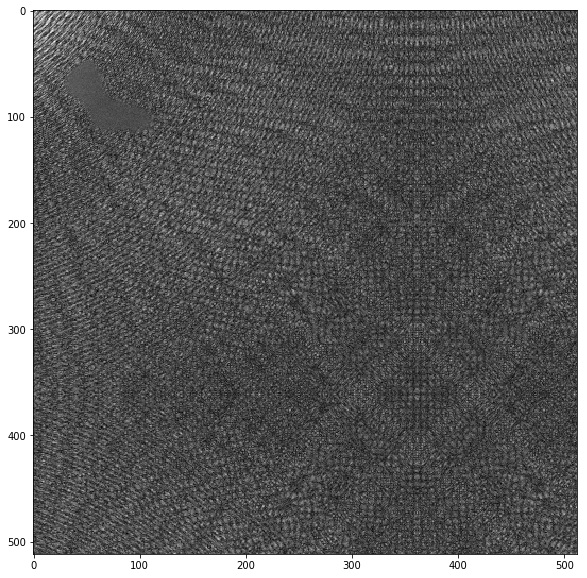

In [10]:
img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')

As we can see in this figure, there exists a defective area in the top left corner. We will now load the model and carry out inference on the normalized test image.

In [0]:
# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        
        output = sess.run([outputs, logits], feed_dict={tf_input: img})
        


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
[2019-10-17 04:43:33] Conv2D: `UNet_v1/input_block/conv2d/BiasAdd:0`
	[*] data_format: NHWC
	[*] dilation_rate: (1, 1)
	[*] kernel_size: (3, 3)
	[*] n_channels: 32
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)
	[*] padding: same
	[*] strides: (1, 1)
	[*] trainable: True
	[*] use_bias: True

[2019-10-17 04:43:33] ReLU: `UNet_v1/input_block/act1/relu:0`
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)

[2019-10-17 04:43:33] Conv2D: `UNet_v1/input_block/

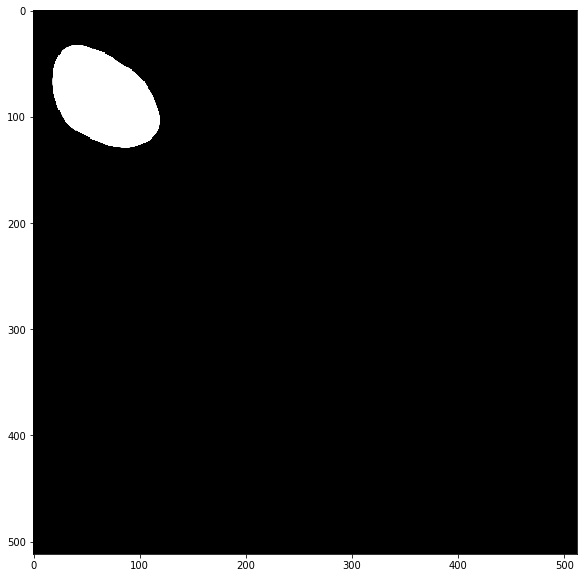

In [13]:
# Print out model predicted mask
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

As expected, the model points out the correct defective area in this image. Please feel free to try out other defective images within `./data/raw_images/public/Class1_def/`

In [14]:
!ls ./data/raw_images/public/Class1_def/

100.png  116.png  131.png  147.png  26.png  41.png  57.png  72.png  88.png
101.png  117.png  132.png  148.png  27.png  42.png  58.png  73.png  89.png
102.png  118.png  133.png  149.png  28.png  43.png  59.png  74.png  8.png
103.png  119.png  134.png  14.png   29.png  44.png  5.png   75.png  90.png
104.png  11.png   135.png  150.png  2.png   45.png  60.png  76.png  91.png
105.png  120.png  136.png  15.png   30.png  46.png  61.png  77.png  92.png
106.png  121.png  137.png  16.png   31.png  47.png  62.png  78.png  93.png
107.png  122.png  138.png  17.png   32.png  48.png  63.png  79.png  94.png
108.png  123.png  139.png  18.png   33.png  49.png  64.png  7.png   95.png
109.png  124.png  13.png   19.png   34.png  4.png   65.png  80.png  96.png
10.png	 125.png  140.png  1.png    35.png  50.png  66.png  81.png  97.png
110.png  126.png  141.png  20.png   36.png  51.png  67.png  82.png  98.png
111.png  127.png  142.png  21.png   37.png  52.png  68.png  83.png  99.png
112.png  128.png  143.png  

## Convert model to ONNX


In [15]:
!pip install --no-binary onnx 'onnx==1.6.0'
!pip install -U tf2onnx

     |████████████████████████████████| 3.1MB 2.7MB/s 
Skipping bdist_wheel for onnx, due to binaries being disabled for it.
  Running setup.py install for onnx ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-a2p9yvh6/onnx/setup.py'"'"'; __file__='"'"'/tmp/pip-install-a2p9yvh6/onnx/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-fnnbybk8/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 4.8MB 45.1MB/s 


In [16]:
SAVED_MODEL_DIR = "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/saved_model"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        
        output = sess.run([outputs, logits], feed_dict={tf_input: img})
        
        print('Saving model to %s'%SAVED_MODEL_DIR)
        tf.saved_model.simple_save(
            session=sess,
            export_dir=SAVED_MODEL_DIR,
            inputs={"input":tf.get_default_graph().get_tensor_by_name("input:0")},
            outputs={"mask":tf.get_default_graph().get_tensor_by_name("UNet_v1/sigmoid:0")},
            legacy_init_op=None
         )

[2019-10-17 04:44:04] Conv2D: `UNet_v1/input_block/conv2d/BiasAdd:0`
	[*] data_format: NHWC
	[*] dilation_rate: (1, 1)
	[*] kernel_size: (3, 3)
	[*] n_channels: 32
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)
	[*] padding: same
	[*] strides: (1, 1)
	[*] trainable: True
	[*] use_bias: True

[2019-10-17 04:44:04] ReLU: `UNet_v1/input_block/act1/relu:0`
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)

[2019-10-17 04:44:04] Conv2D: `UNet_v1/input_block/conv2d_1/BiasAdd:0`
	[*] data_format: NHWC
	[*] dilation_rate: (1, 1)
	[*] kernel_size: (3, 3)
	[*] n_channels: 32
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)
	[*] padding: same
	[*] strides: (1, 1)
	[*] trainable: True
	[*] use_bias: True

[2019-10-17 04:44:04] ReLU: `UNet_v1/input_block/act2/relu:0`
	[*] out_dtype: <dtype: 'float32'>
	[*] out_shape: (?, 512, 512, 32)

[2019-10-17 04:44:04] MaxPooling2D: `UNet_v1/input_block/max_pooling2d/MaxPool:0`
	[*] data_format: NHWC

In [17]:
!saved_model_cli show --all --dir $SAVED_MODEL_DIR


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 512, 512, 1)
        name: input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['mask'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 512, 512, 1)
        name: UNet_v1/sigmoid:0
  Method name is: tensorflow/serving/predict


In [18]:
# convert model to onnx
!python -m tf2onnx.convert  --saved-model $SAVED_MODEL_DIR --fold_const --output "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx"



2019-10-17 04:44:13,646 - WARNING - From /usr/local/lib/python3.6/dist-packages/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2019-10-17 04:44:14,188 - INFO - NumExpr defaulting to 2 threads.
2019-10-17 04:44:15,703 - INFO - Using tensorflow=1.15.0-rc3, onnx=1.6.0, tf2onnx=1.5.3/7b598d
2019-10-17 04:44:15,703 - INFO - Using opset <onnx, 7>
2019-10-17 04:44:16,001 - INFO - Optimizing ONNX model
2019-10-17 04:44:16,316 - INFO - After optimization: Add -23 (23->0), Const -9 (57->48), Identity -5 (5->0), Reshape +2 (0->2), Transpose -62 (62->0)
2019-10-17 04:44:16,324 - INFO - 
2019-10-17 04:44:16,324 - INFO - Successfully converted TensorFlow model JoC_UNET_Industrial_FP32_TF_20190522/Class+1/saved_model to ONNX
2019-10-17 04:44:16,335 - INFO - ONNX model is saved at JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx


## Installing TensorRT on Colab

In this section, instead of doing inference with the naitive TensorFlow environment, we will first optimize the model with TensorRT, then doing inference with the TensorRT runtime.

We first need to install NVIDIA TensorRT 6 on Colab.

In [0]:
!dpkg -l | grep TensorRT

In [20]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Ign:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:3 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [819 B]
Get:7 http://devel

--2019-10-17 04:46:12--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 192.229.232.112, 2606:2800:247:2063:46e:21d:825:102e
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|192.229.232.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100% 89.8M=0s

2019-10-17 04:46:12 (89.8 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.l

In [21]:
!sudo apt-get install libnvinfer6 libnvonnxparsers6 libnvparsers6 libnvinfer-plugin6
!sudo apt-get install libnvinfer-dev libnvonnxparsers-dev libnvparsers-dev libnvinfer-plugin-dev
!sudo apt-get install python-libnvinfer python3-libnvinfer


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cuda-cudart-10-1 cuda-license-10-1 libcublas10
The following NEW packages will be installed:
  cuda-cudart-10-1 cuda-license-10-1 libcublas10 libnvinfer-plugin6
  libnvinfer6 libnvonnxparsers6 libnvparsers6
0 upgraded, 7 newly installed, 0 to remove and 147 not upgraded.
Need to get 114 MB of archives.
After this operation, 330 MB of additional disk space will be used.
Get:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer6 6.0.1-1+cuda10.1 [71.2 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  cuda-license-10-1 10.1.243-1 [16.4 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  cuda-cudart-10-1 10.1.243-1 [109 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcublas10 10.2.1.243-

In [22]:
%%bash
version="6.0.1-1+cuda10.0"
sudo apt-get install libnvinfer6=${version} libnvonnxparsers6=${version} libnvparsers6=${version} libnvinfer-plugin6=${version} libnvinfer-dev=${version} libnvonnxparsers-dev=${version} libnvparsers-dev=${version} libnvinfer-plugin-dev=${version} python-libnvinfer=${version} python3-libnvinfer=${version}
sudo apt-mark hold libnvinfer6 libnvonnxparsers6 libnvparsers6 libnvinfer-plugin6 libnvinfer-dev libnvonnxparsers-dev libnvparsers-dev libnvinfer-plugin-dev python-libnvinfer python3-libnvinfer

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  cuda-cudart-10-1 cuda-cudart-dev-10-1 cuda-driver-dev-10-1 cuda-license-10-1
  libcublas-dev libcublas10
Use 'sudo apt autoremove' to remove them.
The following packages will be DOWNGRADED:
  libnvinfer-dev libnvinfer-plugin-dev libnvinfer-plugin6 libnvinfer6
  libnvonnxparsers-dev libnvonnxparsers6 libnvparsers-dev libnvparsers6
  python-libnvinfer python3-libnvinfer
0 upgraded, 0 newly installed, 10 downgraded, 0 to remove and 147 not upgraded.
Need to get 141 MB of archives.
After this operation, 9,847 kB disk space will be freed.
Get:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  libnvinfer-plugin-dev 6.0.1-1+cuda10.0 [1,756 kB]
Get:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  python-libnvinfer 6.0.1-1+cuda10.0 [371 kB]
Get:3 http://dev

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1


In [23]:
!dpkg -l | grep TensorRT

hi  libnvinfer-dev                          6.0.1-1+cuda10.0                                  amd64        TensorRT development libraries and headers
hi  libnvinfer-plugin-dev                   6.0.1-1+cuda10.0                                  amd64        TensorRT plugin libraries
hi  libnvinfer-plugin6                      6.0.1-1+cuda10.0                                  amd64        TensorRT plugin libraries
hi  libnvinfer6                             6.0.1-1+cuda10.0                                  amd64        TensorRT runtime libraries
hi  libnvonnxparsers-dev                    6.0.1-1+cuda10.0                                  amd64        TensorRT ONNX libraries
hi  libnvonnxparsers6                       6.0.1-1+cuda10.0                                  amd64        TensorRT ONNX libraries
hi  libnvparsers-dev                        6.0.1-1+cuda10.0                                  amd64        TensorRT parsers libraries
hi  libnvparsers6                           6.0.1-1+cu

A successful TensorRT 6.0 installation should look like:

```
hi  libnvinfer-dev                          6.0.1-1+cuda10.0                                  amd64        TensorRT development libraries and headers
hi  libnvinfer-plugin-dev                   6.0.1-1+cuda10.0                                  amd64        TensorRT plugin libraries
hi  libnvinfer-plugin6                      6.0.1-1+cuda10.0                                  amd64        TensorRT plugin libraries
hi  libnvinfer6                             6.0.1-1+cuda10.0                                  amd64        TensorRT runtime libraries
hi  libnvonnxparsers-dev                    6.0.1-1+cuda10.0                                  amd64        TensorRT ONNX libraries
hi  libnvonnxparsers6                       6.0.1-1+cuda10.0                                  amd64        TensorRT ONNX libraries
hi  libnvparsers-dev                        6.0.1-1+cuda10.0                                  amd64        TensorRT parsers libraries
hi  libnvparsers6                           6.0.1-1+cuda10.0                                  amd64        TensorRT parsers libraries
hi  python-libnvinfer                       6.0.1-1+cuda10.0                                  amd64        Python bindings for TensorRT
hi  python3-libnvinfer                      6.0.1-1+cuda10.0                                  amd64        Python 3 bindings for TensorRT                 
```

Next, we install the latest TensorRT open source component (OSS).

In [0]:
!which trtexec

In [25]:
%%bash
git clone -b master https://github.com/nvidia/TensorRT TensorRT
cd TensorRT
git submodule update --init --recursive
export TRT_SOURCE='pwd'

Submodule path 'parsers/onnx': checked out 'b7c0840493e72891096771d000d6de26a03aed62'
Submodule path 'parsers/onnx/third_party/onnx': checked out 'ae14574d23c84b6590b22df329a2e118e205486f'
Submodule path 'parsers/onnx/third_party/onnx/third_party/benchmark': checked out 'e776aa0275e293707b6a0901e0e8d8a8a3679508'
Submodule path 'parsers/onnx/third_party/onnx/third_party/pybind11': checked out 'a1041190c8b8ff0cd9e2f0752248ad5e3789ea0c'
Submodule path 'parsers/onnx/third_party/onnx/third_party/pybind11/tools/clang': checked out '6a00cbc4a9b8e68b71caf7f774b3f9c753ae84d5'
Submodule path 'third_party/cub': checked out 'c3cceac115c072fb63df1836ff46d8c60d9eb304'
Submodule path 'third_party/protobuf': checked out 'b10d490efd6052a02a90277e3325adbec6ce62eb'
Submodule path 'third_party/protobuf/third_party/benchmark': checked out '5b7683f49e1e9223cf9927b24f6fd3d6bd82e3f8'
Submodule path 'third_party/protobuf/third_party/googletest': checked out '5ec7f0c4a113e2f18ac2c6cc7df51ad6afc24081'


Cloning into 'TensorRT'...
Submodule 'parsers/onnx' (https://github.com/onnx/onnx-tensorrt.git) registered for path 'parsers/onnx'
Submodule 'third_party/cub' (https://github.com/NVlabs/cub.git) registered for path 'third_party/cub'
Submodule 'third_party/protobuf' (https://github.com/protocolbuffers/protobuf.git) registered for path 'third_party/protobuf'
Cloning into '/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/parsers/onnx'...
Cloning into '/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/third_party/cub'...
Cloning into '/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/third_party/protobuf'...
Submodule 'third_party/onnx' (https://github.com/onnx/onnx.git) registered for path 'parsers/onnx/third_party/onnx'
Cloning into '/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/parsers/onnx/third_party/onnx'...
Submodule 'third_

TensorRT OSS requires cmake version 3.13. So before proceeding, we shall install the latest cmake version as necessary. Note that these steps might take a while to complete.

In [26]:
!cmake --version

cmake version 3.12.0

CMake suite maintained and supported by Kitware (kitware.com/cmake).


In [27]:
!sudo apt purge --auto-remove cmake

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  cmake* cmake-data* cuda-cudart-10-1* cuda-cudart-dev-10-1*
  cuda-driver-dev-10-1* cuda-license-10-1* libarchive13* libcublas-dev*
  libcublas10* liblzo2-2* librhash0* libuv1*
0 upgraded, 0 newly installed, 12 to remove and 156 not upgraded.
After this operation, 230 MB disk space will be freed.
(Reading database ... 131366 files and directories currently installed.)
Removing cmake (3.10.2-1ubuntu2.18.04.1) ...
Removing cmake-data (3.10.2-1ubuntu2.18.04.1) ...
Removing cuda-cudart-dev-10-1 (10.1.243-1) ...
Removing cuda-cudart-10-1 (10.1.243-1) ...
Removing cuda-driver-dev-10-1 (10.1.243-1) ...
Removing libcublas-dev (10.2.1.243-1) ...
Removing libcublas10 (10.2.1.243-1) ...
Removing cuda-license-10-1 (10.1.243-1) ...
Removing libarchive13:amd64 (3.2.2-3.1ubuntu0.3) ...
Removing liblzo2-2:amd64 (2.08-1.2) ...
Removing librhash0:amd64 (1.3.6-2) ...
Re

In [28]:
%%bash
version=3.15
build=4
mkdir ~/temp
cd ~/temp
wget https://cmake.org/files/v$version/cmake-$version.$build.tar.gz
tar -xzvf cmake-$version.$build.tar.gz
cd cmake-$version.$build/

./bootstrap
make -j$(nproc)
sudo make install



cmake-3.15.4/Packaging/
cmake-3.15.4/Packaging/CMakeDMGSetup.scpt
cmake-3.15.4/Packaging/QtSDK/
cmake-3.15.4/Packaging/QtSDK/qt.tools.cmake.xx.qs.in
cmake-3.15.4/Packaging/QtSDK/ToolsCMakeXX.cmake
cmake-3.15.4/Packaging/CMakeDMGBackground.tif
cmake-3.15.4/DartConfig.cmake
cmake-3.15.4/CMakeLogo.gif
cmake-3.15.4/CMakeCPackOptions.cmake.in
cmake-3.15.4/CMakeLists.txt
cmake-3.15.4/Copyright.txt
cmake-3.15.4/bootstrap
cmake-3.15.4/CONTRIBUTING.rst
cmake-3.15.4/Licenses/
cmake-3.15.4/Licenses/LGPLv3.txt
cmake-3.15.4/Licenses/LGPLv2.1.txt
cmake-3.15.4/Licenses/README.rst
cmake-3.15.4/configure
cmake-3.15.4/cmake_uninstall.cmake.in
cmake-3.15.4/CTestConfig.cmake
cmake-3.15.4/Source/
cmake-3.15.4/Source/cmQtAutoGen.cxx
cmake-3.15.4/Source/cmNinjaNormalTargetGenerator.h
cmake-3.15.4/Source/cmCPluginAPI.cxx
cmake-3.15.4/Source/cmGlobalVisualStudioGenerator.h
cmake-3.15.4/Source/cmIDEOptions.h
cmake-3.15.4/Source/cmGlobalJOMMakefileGenerator.h
cmake-3.15.4/Source/cmLocale.h
cmake-3.15.4/Source/cm

--2019-10-17 04:49:48--  https://cmake.org/files/v3.15/cmake-3.15.4.tar.gz
Resolving cmake.org (cmake.org)... 66.194.253.19
Connecting to cmake.org (cmake.org)|66.194.253.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9270648 (8.8M) [application/x-gzip]
Saving to: ‘cmake-3.15.4.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  132K 68s
    50K .......... .......... .......... .......... ..........  1%  265K 51s
   100K .......... .......... .......... .......... ..........  1% 62.9M 34s
   150K .......... .......... .......... .......... ..........  2% 42.2M 25s
   200K .......... .......... .......... .......... ..........  2%  266K 27s
   250K .......... .......... .......... .......... ..........  3% 46.1M 22s
   300K .......... .......... .......... .......... ..........  3% 44.7M 19s
   350K .......... .......... .......... .......... ..........  4% 63.3M 16s
   400K .......... .......... .......... .......... ..........  4%

In [29]:
!cmake --version

cmake version 3.15.4

CMake suite maintained and supported by Kitware (kitware.com/cmake).


Note: the next step compiles and install TensorRT open source component and will take a while to complete.

In [30]:
 %%bash
 cd TensorRT
 rm -r build
 mkdir -p build && cd build 
 cmake .. -DTRT_LIB_DIR=/usr/lib/x86_64-linux-gnu/ -DTRT_BIN_DIR='pwd'/out
 make -j$(nproc)
 sudo make install

-- The CXX compiler identification is GNU 7.4.0
-- The CUDA compiler identification is NVIDIA 10.0.130
-- Check for working CXX compiler: /usr/bin/g++
-- Check for working CXX compiler: /usr/bin/g++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc -- works
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Targeting TRT Platform: x86_64
-- CUDA version set to 10.1
-- cuDNN version set to 7.5
-- Protobuf version set to 3.0.0
-- Looking for C++ include pthread.h
-- Looking for C++ include pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in p

rm: cannot remove 'build': No such file or directory
Building for TensorRT version: 6.0.1.0, library version: 6.0.1
CMake Warning (dev) at install.cmake:41 (message):
  The file
  "/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/third_party.protobuf/src/third_party.protobuf/src/google/protobuf/repeated_field_reflection.h"
  is listed in
  "/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/third_party.protobuf/src/third_party.protobuf/cmake/cmake/extract_includes.bat.in"
  but there not exists.  The file will not be installed.
Call Stack (most recent call first):
  CMakeLists.txt:169 (include)
This warning is for project developers.  Use -Wno-dev to suppress it.

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/plugin/common/kernels/proposalKernel.cu(34): warning: variable "ALIGNMENT" was declared but never referenced

/content/DeepLearningExamples/TensorFl

In [0]:
!cp /usr/lib/x86_64-linux-gnu/../lib/*  /usr/lib/x86_64-linux-gnu/
!cp -r  /usr/lib/x86_64-linux-gnu/../bin/* /usr/bin
!cp /usr/lib/x86_64-linux-gnu/../include/* /usr/incude

In [10]:
!ls /usr/lib/x86_64-linux-gnu/*nv* -l


lrwxrwxrwx 1 root root        27 Nov 30  2016 /usr/lib/x86_64-linux-gnu/libdouble-conversion.so.1 -> libdouble-conversion.so.1.0
-rw-r--r-- 1 root root     67648 Nov 30  2016 /usr/lib/x86_64-linux-gnu/libdouble-conversion.so.1.0
lrwxrwxrwx 1 root root        23 Jul 31 06:15 /usr/lib/x86_64-linux-gnu/libEGL_nvidia.so.0 -> libEGL_nvidia.so.430.40
-rw-r--r-- 1 root root   1272912 Jul 21 09:59 /usr/lib/x86_64-linux-gnu/libEGL_nvidia.so.430.40
lrwxrwxrwx 1 root root        29 Jul 31 06:15 /usr/lib/x86_64-linux-gnu/libGLESv1_CM_nvidia.so.1 -> libGLESv1_CM_nvidia.so.430.40
-rw-r--r-- 1 root root     61136 Jul 21 09:58 /usr/lib/x86_64-linux-gnu/libGLESv1_CM_nvidia.so.430.40
lrwxrwxrwx 1 root root        26 Jul 31 06:15 /usr/lib/x86_64-linux-gnu/libGLESv2_nvidia.so.2 -> libGLESv2_nvidia.so.430.40
-rw-r--r-- 1 root root    110904 Jul 21 09:58 /usr/lib/x86_64-linux-gnu/libGLESv2_nvidia.so.430.40
lrwxrwxrwx 1 root root        23 Jul 31 06:15 /usr/lib/x86_64-linux-gnu/libGLX_nvidia.so.0 -> libGLX_n

In [36]:
%env LD_LIBRARY_PATH=/usr/lib64-nvidia:/usr/lib/x86_64-linux-gnu

env: LD_LIBRARY_PATH=/usr/lib64-nvidia:/usr/lib/x86_64-linux-gnu


In [38]:
!find / -name libnvinfer_plugin*

/usr/lib/x86_64-linux-gnu/libnvinfer_plugin_static.a
/usr/lib/x86_64-linux-gnu/libnvinfer_plugin.so
/usr/lib/x86_64-linux-gnu/libnvinfer_plugin.so.6.0.1.0
/usr/lib/x86_64-linux-gnu/libnvinfer_plugin.so.6
/usr/lib/x86_64-linux-gnu/libnvinfer_plugin.so.6.0.1
/usr/lib/lib/libnvinfer_plugin.so
/usr/lib/lib/libnvinfer_plugin.so.6.0.1.0
/usr/lib/lib/libnvinfer_plugin.so.6.0.1
/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/plugin/pwd/out/libnvinfer_plugin_static.a
/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/plugin/pwd/out/libnvinfer_plugin.so
/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/plugin/pwd/out/libnvinfer_plugin.so.6.0.1.0
/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/TensorRT/build/plugin/pwd/out/libnvinfer_plugin.so.6.0.1


In [11]:

!LD_LIBRARY_PATH=/usr/lib64-nvidia:/usr/lib/x86_64-linux-gnu trtexec --onnx=/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx --explicitBatch --minShapes=\'input:0\':1x512x512x1


&&&& RUNNING TensorRT.trtexec # trtexec --onnx=/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx --explicitBatch --minShapes='input:0':1x512x512x1
[09/17/2019-05:32:37] [I] === Model Options ===
[09/17/2019-05:32:37] [I] Format: ONNX
[09/17/2019-05:32:37] [I] Model: /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx
[09/17/2019-05:32:37] [I] Output:
[09/17/2019-05:32:37] [I] === Build Options ===
[09/17/2019-05:32:37] [I] Max batch: explicit
[09/17/2019-05:32:37] [I] Workspace: 16 MB
[09/17/2019-05:32:37] [I] minTiming: 1
[09/17/2019-05:32:37] [I] avgTiming: 8
[09/17/2019-05:32:37] [I] Precision: FP32
[09/17/2019-05:32:37] [I] Calibration: 
[09/17/2019-05:32:37] [I] Safe mode: Disabled
[09/17/2019-05:32:37] [I] Save engine: 
[09/17/2019-05:32:37] [I] Load engine: 
[09/17/2019-05:32:37] [I] Inputs format: fp32:CHW
[09/

## Optimize model and inference with TensorRT

Next, we are ready to optimize the model for inference with TensorRT. This is carried out in the following steps:

- Import ONNX model
- Create optimize TensorRT model
- Inference.

**Precision mode:** The model that TensorRT optimizes can have the graph or parameters stored in float32 (FP32) or float16 (FP16). Regardless of the datatype of the model, TensorRT can convert tensors and weights to lower precisions during the optimization. The argument `precision_mode` sets the precision mode; which can be one of FP32, FP16, or INT8

### FP32 Inference

In [4]:
import os

WORKSPACE_DIR='/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks'
os.chdir(WORKSPACE_DIR)
print (os.getcwd())

import tensorrt as trt

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks


In [7]:
!ls JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx

JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx


Create the build, network, and parser:

In [0]:
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
def build_engine_onnx(model_file):
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
        builder.max_workspace_size = 2<<20
        # Load the Onnx model and parse it in order to populate the TensorRT network.
        with open(model_file, 'rb') as model:
            parser.parse(model.read())
        return builder.build_cuda_engine(network)
      
engine = build_engine_onnx("JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.onnx")

In [6]:
type(engine)


NoneType

Build the engine using the builder object.

In [0]:
builder.max_batch_size = 64
builder.max_workspace_size = 1 << 20 # This determines the amount of memory available to the builder when building an optimized engine and should generally be set as high as possible.


engine =  builder.build_cuda_engine(network)


In [0]:
type(engine)

NoneType

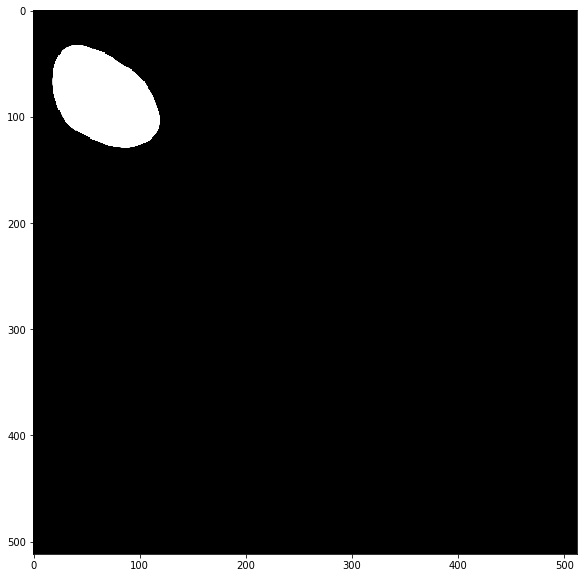

In [0]:
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

Next, we load the saved TF-TRT model and carry out inference.

### FP16 Inference

Next, we convert the model using FP16 precision.

### INT8 Inference

# Conclusion

In this notebook, we have walked through the complete process of carrying out inference using a pretrained UNet-Industrial model.
## What's next
Now it's time to try the UNet-Industrial model on your own data. 